# Adjoint gradient calculation

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAdjointOptimize.ipynb).

This demo will get one started performing gradient-based optimization of a photonic device using the adjoint method. The adjoint method offers an efficient way to compute gradients with respect to any number of design parameters using only two simulations.

The goal of this notebook is to show how to compute this gradient by wrapping Tidy3d. The approach shown here can be used to implement a gradient-based optimization, which will be elucidated in future tutorials.

In the future, Tidy3d will provide a higher-level API for implementing gradient calculations based on this method.  For more details, this [paper](https://pubs.acs.org/doi/10.1021/acsphotonics.9b01238) provides an overview of the derivation of the adjoint method in FDTD ([arxiv preprint](https://arxiv.org/abs/1908.10507)).

In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
import tidy3d.web as web

## Overview

We will look at the transmission of light through 4 dieletric `td.Box()` objects in the x-y plane.

There is a waveguide extending through the x axis.  On one side of the boxes is a modal source and on the other is a modal monitor.

We will measure the mode amplitudes at the mode monitor and compute the total power transmitted, which will server as our objective function.

Then, we will set up an adjoint simulation where several modal sources are located at the measurement position and the phase and amplitude of each of the soucess is dependent on the measured amplitudes.

With both the original (forward) and adjoint simulation fields, we can compute the gradient of the measured intensity with respect to the permittivity of each box by summing the product of the electric fields over each of the box volumes.

Then, we will compute this gradient through a brute force perturbation of each of the box permittivity values, showing that the two gradients match with good accuracy.

### Parameters

First, let's set up some of the parameters of the system.

In [2]:
# wavelength and frequency
wavelength = 1.0
freq0 = td.C_0 / wavelength

# resolution control
dl = 0.02

# space between boxes and PML
buffer = 1.5 * wavelength

# initial size of boxes and waveguide
lx0, ly0, lz0 = 1., 1., 8 * dl
wg_width = .7

# position of source and monitor (constant for all)
source_x = -lx0 - 1
meas_x = lx0 + 1

# total size
Lx = 2 * lx0 + 2 * buffer
Ly = 2 * ly0 + 2 * buffer
Lz = lz0 + 2 * buffer

# simulation parameters
subpixel = False
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())
shutoff = 1e-8
courant = 0.9

# permittivity at each quadrant of box
quadrants = [x + y for x in "+-" for y in "+-"]
permittivities = [2.0, 2.5, 3.0, 3.5]

wg_eps = 2.75
eps_boxes = {quad: eps for (quad, eps) in zip(quadrants, permittivities)}

# frequency width and run time
freqw = freq0 / 10
run_time = 10 / freqw

# polarization of initial source
pol = "Ey"

# monitor for plotting
monitor_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="field_pattern",
)

# default box center and sizes
center = np.array([-1e-5, -1e-5, -1e-5])

size = np.array([lx0, ly0, lz0])
ds = -0.0

### Structures

Next, we'll construct the waveguide and each of the boxes.

We'll give each of these these structures a `.name` representing what quadrant of the x,y plane it is in.

In [3]:
waveguide = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz0)),
    medium=td.Medium(permittivity=wg_eps)
)

boxes_quad = []

for i, (quad, eps) in enumerate(eps_boxes.items()):

    x, y = quad
    xsign = 1 if x == "+" else -1
    ysign = 1 if y == "+" else -1

    center_quad = center.tolist()
    center_quad[0] += xsign * lx0 / 2
    center_quad[1] += ysign * ly0 / 2
    size_quad = size.tolist()
    size_quad[0] += i * ds
    size_quad[1] += i * ds

    box_quad = td.Structure(
        geometry=td.Box(center=center_quad, size=size_quad),
        medium=td.Medium(permittivity=eps),
        name=quad,
    )
    boxes_quad.append(box_quad)

    grad_mon = td.FieldMonitor(
        center=center_quad,
        size=size_quad,
        freqs=[freq0],
        name=quad,
    )

### Construct Gradient Monitors
As discussed, We'll need the fields within each box for both forward and adjoint simulations in order to compute the gradient.

Here we'll construct those and assign each the same name as the corresponding structure.

In [4]:
#The adjoint gradient is computed by summing up the forward * adjoint fields in the whole volume of each Box.
grad_monitors = []
for structure in boxes_quad:
    grad_monitors.append(
        td.FieldMonitor(
            center=structure.geometry.center,
            size=structure.geometry.size,
            freqs=[freq0],
            name=structure.name,
        )
    )

### Construct Base Simulation

With this information, we can create a simulation that contains both the boxes and their gradient monitors.

We'll copy this simulation and use it to construct both the forward and adjoint simuilations in a bit.

In [5]:
sim_base = td.Simulation(
    size=[Lx, Ly, Lz],
    grid_spec=td.GridSpec.uniform(dl=dl),
    # grid_spec=td.GridSpec.auto(wavelength=wavelength),
    structures=[waveguide] + boxes_quad,
    sources=[],
    monitors=[monitor_field] + grad_monitors,
    run_time=run_time,
    subpixel=subpixel,
    boundary_spec=boundary_spec,
    shutoff=shutoff,
    courant=courant,
)

[10:02:09] WARNING  No sources in simulation.                                                     ]8;id=409325;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=863287;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#420\420]8;;\

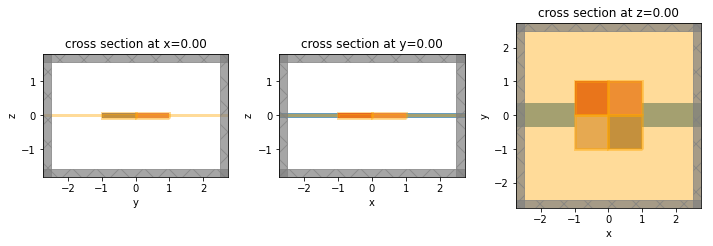

In [6]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

for dim, ax in zip('xyz', axes):
    sim_base.plot(**{dim:0}, ax=ax)

plt.show()

## Forward Simulation

The forward simulation corresponds to the system we want to compute the gradient for.

It will contain a point source and a `FieldMonitor`, which will be used to compute the intensity from the objective function.

In [7]:
sim_forward = sim_base.copy(deep=True)

mode_size = (0,4,3)

# source seeding the simulation
forward_source = td.ModeSource(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
        center=[source_x, 0, 0],
        size=mode_size,
        mode_index=0,
        direction="+"
    )

sim_forward = sim_base.copy(update={'sources': list(sim_forward.sources) + [forward_source]})

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = 'measurement'

num_modes = 3

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, 0, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    name=measurement_monitor_name,
)

sim_forward = sim_forward.copy(update={'monitors': list(sim_forward.monitors) + [measurement_monitor]})

           WARNING  No sources in simulation.                                                     ]8;id=954119;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=597005;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#420\420]8;;\

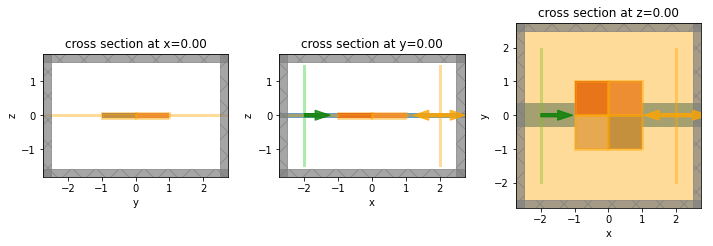

In [8]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

for dim, ax in zip('xyz', axes):
    sim_forward.plot(**{dim:0}, ax=ax)

plt.show()

### Defining Objective Function

Next, we'll define the objective function as the sum of the absolute value of the fields at the "intensity" monitor location.

We write this function as a function of the `SimulationData` returned by the solver to make it simple to compute after the fact.

In [9]:
def compute_objective(sim_data):
    """ Computes both the (complex-valued) electric fields at the measure point and the intensity (the objective function)."""

    # get the measurement monitor fields and positions
    measure_monitor = sim_data.simulation.get_monitor_by_name(measurement_monitor_name)
    measure_amps = sim_data[measurement_monitor_name].amps.sel(direction='+')
    
    # sum their absolute values squared to give intensity
    power = np.sum(np.abs(measure_amps)**2)

    # return both the complex-valued raw fields and the intensity
    return measure_amps, power

### Running forward simulation

Finally, we will run the forward simulation and evaluate the objective function and the fields at the measurement point.

In [10]:
sim_data_forward = web.run(sim_forward, task_name='forward', path='data/forward.hdf5')

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 98.5% • 17.8/18.0 MB • 3.4 MB/s • 0:00:01

[10:03:09] INFO     loading SimulationData from data/forward.hdf5                                     ]8;id=212898;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=914312;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#397\397]8;;\

In [11]:
measured_amps_forward, objective_fn = compute_objective(sim_data_forward)

In [12]:
print(measured_amps_forward, objective_fn)

<xarray.ModeAmpsDataArray (f: 1, mode_index: 3)>
array([[-1.89945947e-15+3.69187639e-16j, -2.06683054e-17-7.71582547e-18j,
        -3.26267054e-16-3.10816494e-16j]])
Coordinates:
    direction   <U1 '+'
  * f           (f) float64 2.998e+14
  * mode_index  (mode_index) int64 0 1 2
Attributes:
    units:      sqrt(W)
    long_name:  mode amplitudes <xarray.DataArray ()>
array(3.9477896e-30)
Coordinates:
    direction  <U1 '+'


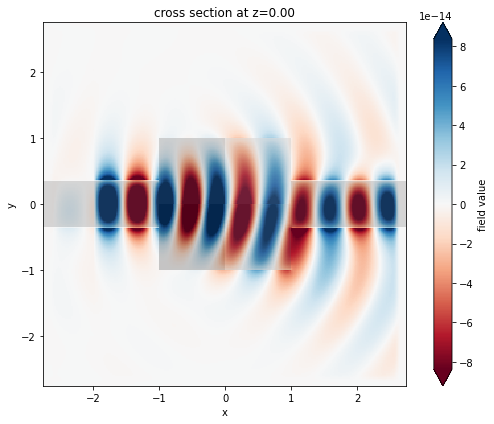

In [13]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(8, 6))
ax = sim_data_forward.plot_field('field_pattern', 'Ey', val='real', f=freq0, ax=ax)

## Adjoint Problem

Now that we have the fields at the measurement position, we can define the adjoint source and simulation.

### Adjoint source

The adjoint source is defined by the derivative of the forward objective with respect to its fields.

Since the objective here is given by the norm squared of each of the modal amplitudes, it's simple to show that the adjoint source is composed of the sum of each of the modal profiles, each weighted with the complex conjugate of the respecitve amplitude.

Therefore, we will inject a point source for each component of the measured E with the correct amplitude and phase to take the complex conjugate into account.

In [14]:
adjoint_sources = []

for mode_index in range(num_modes):

    amp_forward = complex(measured_amps_forward.sel(mode_index=mode_index).values)
    
    adjoint_sources.append(
        td.ModeSource(
            source_time=td.GaussianPulse(
                freq0=freq0,
                fwidth=freqw,
                phase=float(- np.angle(amp_forward)),
                # phase=float(+ np.pi / 2 - np.angle(amp_forward)),
                amplitude=np.abs(amp_forward),
            ),
            center=measurement_monitor.center,
            size=measurement_monitor.size,
            direction="-",
            mode_index=mode_index,
        )
    )

### Adjont simulation

We then make an adjoint simulation, which is just a copy of the base simulation with the adjoint sources added.

In [15]:
sim_adjoint = sim_base.copy(update={'sources': list(sim_base.sources) + adjoint_sources})

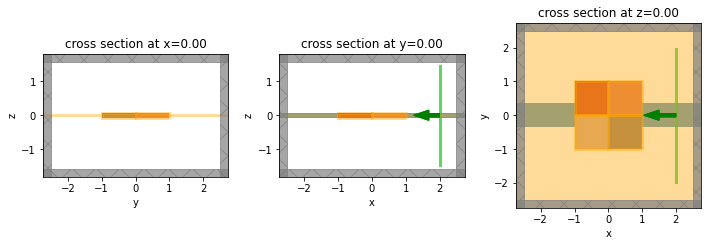

In [16]:
f, axes = plt.subplots(1, 3, tight_layout=True, figsize=(10, 5))

for dim, ax in zip('xyz', axes):
    sim_adjoint.plot(**{dim:0}, ax=ax)

plt.show()

### Running adjoint simulation

Let's run the adjoint simulation to get the adjoint fields at the box locations so we can compute the gradient.

In [17]:
sim_data_adjoint = web.run(sim_adjoint, task_name='adjoint', path='data/adjoint.hdf5')

↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 18.0/18.0 MB • 1.6 MB/s • 0:00:00

[10:04:07] INFO     loading SimulationData from data/adjoint.hdf5                                     ]8;id=7984;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=750529;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#397\397]8;;\

           WARNING  'freq' suppled to 'plot_field', frequency selection key renamed to 'f' and      ]8;id=79214;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=588682;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#316\316]8;;\
                    'freq' will error in future release, please update your local script to use                    
                    'f=value'.                                                                                     

[10:04:08] WARNING  'freq' suppled to 'plot_field', frequency selection key renamed to 'f' and      ]8;id=301098;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py\sim_data.py]8;;\:]8;id=33245;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/components/data/sim_data.py#316\316]8;;\
                    'freq' will error in future release, please update your local script to use                    
                    'f=value'.                                                                                     

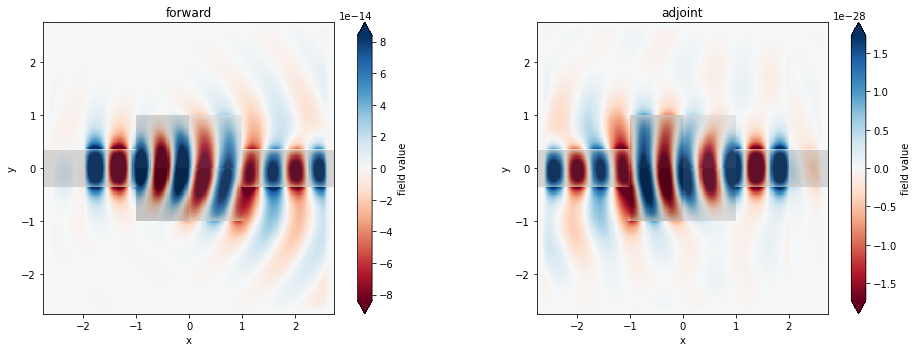

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(14, 5))

ax1 = sim_data_forward.plot_field('field_pattern', 'Ey', val='real', freq=freq0, ax=ax1)
ax2 = sim_data_adjoint.plot_field('field_pattern', 'Ey', val='real', freq=freq0, ax=ax2)

ax1.set_title('forward')
ax2.set_title('adjoint')
plt.show()

### Computing adjoint gradient

Now that we have both the forward and adjoint fields at the box locations, we can compute the gradient by taking the product of the electric field components and summing them over the volume of each box.

We'll write two functions to help out with this.  

1. The first will grab the electric fields within the box volumes at the yee cell locations.  Note that the first and last cells are placed outside of the box volume to be able to interpolate to the box boundaries, so those can be excluded with the `slice(first, last)` operation.

2. The second will unpack the electric fields for both forward and adjoint simulations and sum their products together.  The result will be a dictionary mapping the orginal structure names to the gradient of the measured intensity with respect to the structure permittivity.

In [19]:
def unpack_grad_monitors(sim_data):
    """Grab the electric field within each of the structures' volumes and package as a dictionary."""
    
    def select_volume_data(scalar_field_data, box):
        """select the fields within the volume of a box, excluding boundaries."""
        scalar_field_f0 = scalar_field_data.isel(f=0)

        # grab the coordinates of the data
        xs = scalar_field_f0.coords['x']
        ys = scalar_field_f0.coords['y']
        zs = scalar_field_f0.coords['z']
        
        # get the bounds of the box
        (xmin, ymin, zmin), (xmax, ymax, zmax) = box.bounds

        # compute the indices where the coordinates are inside the box
        in_x = np.where(np.logical_and(xs >= xmin, xs <= xmax))
        in_y = np.where(np.logical_and(ys >= ymin, ys <= ymax))
        in_z = np.where(np.logical_and(zs >= zmin, zs <= zmax))
        
        # select the coordinates at these indices
        x_sel = xs[in_x]
        y_sel = ys[in_y]
        z_sel = zs[in_z]
    
        # select the scalar field data only at the points inside the box
        return scalar_field_f0.sel(x=x_sel, y=y_sel, z=z_sel)

    
    def unpack_box(field_data, box):
        """Unpack an individual FieldData for a given box."""
    
        # get the electric field components
        Ex = field_data.Ex
        Ey = field_data.Ey
        Ez = field_data.Ez

        # select their volume data and stack together along first axis
        fields_in_volume = [select_volume_data(field, box) for field in (Ex, Ey, Ez)]
        return fields_in_volume
        
    # unpack field data in each box
    return {box.name: unpack_box(sim_data[box.name], box.geometry) for box in boxes_quad}


def calc_gradient_adjoint_yee(sim_data_forward, sim_data_adjoint, **kwargs):
    """Compute the gradient from both the forward SimulationData and the adjoint SimulationData."""

    # grab the electric fields from forward and adjoint at each of the box locations
    E_dict_forward = unpack_grad_monitors(sim_data_forward)
    E_dict_adjoint = unpack_grad_monitors(sim_data_adjoint)

    def compute_derivate(E_forward, E_adjoint):
        """Compute adjoint derivative given the forward and adjoint fields within a box."""
        dV = dl ** 3
        field_sums = [np.sum(dV * Efor * Eadj) for Efor, Eadj in zip(E_forward, E_adjoint)]
        return sum(field_sums)

    # compute gradient for each box
    return {quad: compute_derivate(E_dict_forward[quad], E_dict_adjoint[quad]) for quad in quadrants}


Now we can call this function on our forwrd and adjoint simulation data.

In [20]:
grad_adj_dict = calc_gradient_adjoint_yee(sim_data_forward, sim_data_adjoint)

## Numerical Gradient

As a sanity check, we can compare our adjoint-computed gradient against one computed using numerical derivatives.

Recall that the derivative of a function `f(x)` can be approximated using numerical derivatives using `df/dx ~ [f(x+d) - f(x-d)] / 2d` and a step size of `d`.

Therefore, we can approximate the gradient by running two forward simulations for each box, where we manually shift the permittivity by a small `d` value and compute the change in objective function value.

We note that compared to adjoint, this is extremely inneficient as it requires `O(N)` simulations to compute a gradient of length `N`, wheras adjoint only requires a single additional simulaton and is therefore `O(1)`.

So this approach works best for checking on small problems, such as this one, where `N=4`.

In [21]:
# step size
delta = 1e-3

sims_batch_numerical = {}

for quad_name in quadrants:
    
    def perturb_sim(quad_name, sign):
        perturbed_structures = []
        for structure in sim_forward.structures:
            if structure.name == quad_name:
                new_medium = structure.medium.copy(update={'permittivity': structure.medium.permittivity + sign * delta})
                structure = structure.copy(update={'medium': new_medium})
            perturbed_structures.append(structure)
        return sim_forward.copy(update={'structures': perturbed_structures})
    
    sims_batch_numerical[quad_name + '_plus'] = perturb_sim(quad_name, +1)
    sims_batch_numerical[quad_name + '_minus'] = perturb_sim(quad_name, -1)
    
# run a batch of each of these 8 calculations at once
batch_data = web.Batch(simulations=sims_batch_numerical).run(path_dir='data')

++_plus: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
++_minus: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
+-_plus: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
+-_minus: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
-+_plus: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
-+_minus: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
--_plus: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
--_minus: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[10:11:18] Batch complete.                                                                         ]8;id=467190;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=392124;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#374\374]8;;\

### Computing numerical derivatve

Next, we use the numerical derivative formula to compute the derivative.

In [22]:
# dict to store the objective functions {name: [f(x-d), f(x+d)]} for each simulation in batch
obj_dict = {name:[None, None] for name in quadrants}

for task_name, sim_data_delta in batch_data.items():

    # compute the objective function f(x)
    _, objective_fn_delta = compute_objective(sim_data_delta)
    
    # grab the original monitor name and also the direction of perturbation
    monitor_name, pm = task_name.split('_')
    index = 0 if pm == 'minus' else 1
    
    # add this objective function to the dict
    obj_dict[monitor_name][index] = objective_fn_delta

# process the objective function dict to compute the numerical derivative
grad_num_dict = {}
for monitor_name in quadrants:
    
    # strip out [f(x-d), f(x+d)]
    objective_fn_minus, objective_fn_plus = obj_dict[monitor_name]
    
    # compute [f(x+d) - f(x-d)] / 2d
    grad_num = (objective_fn_plus - objective_fn_minus) / 2 / delta
    grad_num_dict[monitor_name] = grad_num


↓ monitor_data.hdf5 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 98.5% • 17.8/18.0 MB • 1.7 MB/s • 0:00:01

[10:13:02] INFO     loading SimulationData from data/79c95cb4-1dd3-4eba-989e-c6ee6a362b66.hdf5        ]8;id=63919;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=551340;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#397\397]8;;\

### Normalize and compare

Finally, we can normalize the gradients (since the more important quantity is the direction) and compare them.

In [23]:
def normalize(grad_dict):
    """Normalize the gradient dictionary and return a normalized array."""

    # convert to array
    grad_arr = np.array(list(grad_dict.values()))
    
    # take real part, if not already real
    grad_arr = np.real(grad_arr)

    # normalize
    return grad_arr / np.linalg.norm(grad_arr)

# normalize both adjoint and numerical gradients
g_adj_arr = normalize(grad_adj_dict)
g_num_arr = normalize(grad_num_dict)

# print results
print("Adjoint gradient:   ", g_adj_arr)
print("Numerical gradient: ", g_num_arr)
print(f"RMS error {(np.linalg.norm(g_adj_arr - g_num_arr) / np.linalg.norm(g_num_arr)*100):.2f} %")

Adjoint gradient:    [ 0.73870421 -0.20049994  0.24816493 -0.5937424 ]
Numerical gradient:  [ 0.7285182  -0.2059797   0.24919895 -0.60393169]
RMS error 1.54 %


We see that they match with a small RMS error.